In [1]:
from kaiseki import lattice
from kaiseki import kakunou_kai
from kaiseki import Short_Algo_kai
from kaiseki import Long_kaiseki
import time
import numpy as np
import pandas as pd
import scipy.optimize as optimize
import scipy.sparse as spsp
import matplotlib.pyplot as plt
import csv
import os

from scipy.spatial import distance
from scipy.optimize import linprog
from scipy.optimize import minimize
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D

In [87]:
E = 10
Col = 10

K = Col * Col

M = 50
N = 50

# Scaling * tが格子の最小距離となる。
Scaling = 10.0 / Col

city_network = lattice.make_lattice(Col)

# 通勤費用パラメータ
t = 0.1

# 距離抵抗パラメータ
tau = 0.5

# 総土地供給量
# S_total = K
# S_bar = S_total / K
S_total = 100
S_bar = S_total / K

#境界あり
Coordinate_Data = \
np.array([(city_network['node_dic'][str(i)]['x_pos']*Scaling,
           city_network['node_dic'][str(i)]['y_pos']*Scaling) for i in range(K)])
distance_matrix = distance.squareform(distance.pdist(Coordinate_Data))

#境界なし
# Periodic = lattice.MakePeriodicDistanceMatrix(Col, Scaling)
# Periodic.add_distance_row()
# distance_matrix = Periodic.distance_matrix

theta_firm = 1.0
theta_house = 1.0

alpha_1 = 0.4
alpha_2 = 0.4
beta_1 = 0.4
beta_2 = 0.4

m_per = M / K
m0 = np.array([m_per] * K)
n0 = np.full((K, K), N / (K * K))

method = "FISTA"
dic = "Scaling=30"
#パラメータ設定
prm = Long_kaiseki.Parameter(Col, distance_matrix, t, tau, Scaling, S_total, S_bar,
            theta_firm, theta_house, E, alpha_1, alpha_2, beta_1, beta_2, M, N)

long = Long_kaiseki.Long(prm)

In [88]:
%%time
m_true, n_true, RW = long.solve(m0, n0, long_itr=800, err_long=1e-4)

long_max_value: 458
Lyapunov: -1.4779288903810084e-12
CPU times: total: 172 ms
Wall time: 174 ms


In [89]:
R_true = ((prm.alpha_1 * np.sum(n_true, axis=1) + prm.beta_1 * m_true) / prm.S_bar)
W_true = (1.0 / prm.E) * (prm.beta_2 * (m_true / np.sum(n_true, axis=0)) + prm.alpha_2)

short = Short_Algo_kai.Short(prm, m_true, n_true)

S_H, L_H, S_F, L_F = short.demand(R_true, W_true)

In [105]:
R_true

array([ 0.18164406,  0.18661861,  0.19064776,  0.1936484 ,  0.19528535,
        0.19543185,  0.19406708,  0.19128838,  0.18741749,  0.18254571,
        0.18661861,  0.19239252,  0.19706707,  0.20058834,  0.20253707,
        0.20273225,  0.20113328,  0.19787255,  0.19335427,  0.18766942,
        0.19064776,  0.19706707,  0.2023388 ,  0.20631538,  0.20860539,
        0.20887982,  0.20704877,  0.20336468,  0.19823572,  0.19186446,
        0.1936484 ,  0.20058834,  0.20631538,  0.21071532,  0.21343653,
        0.21386346,  0.21175205,  0.2076222 ,  0.20197585,  0.19502569,
        0.19528535,  0.20253707,  0.20860539,  0.21343653,  0.21672906,
        0.2175403 ,  0.21496868,  0.21023105,  0.20412374,  0.19679981,
        0.19543185,  0.20273225,  0.20887982,  0.21386346,  0.2175403 ,
       20.14588955,  0.21579031,  0.21066912,  0.20440651,  0.19700146,
        0.19406708,  0.20113328,  0.20704877,  0.21175205,  0.21496868,
        0.21579031,  0.21329218,  0.20868618,  0.20273162,  0.19

In [90]:
W_true

array([0.04      , 0.04      , 0.04      , 0.04      , 0.04      ,
       0.04      , 0.04      , 0.04      , 0.04      , 0.04      ,
       0.04      , 0.04      , 0.04      , 0.04      , 0.04      ,
       0.04      , 0.04      , 0.04      , 0.04      , 0.04      ,
       0.04      , 0.04      , 0.04      , 0.04      , 0.04      ,
       0.04      , 0.04      , 0.04      , 0.04      , 0.04      ,
       0.04      , 0.04      , 0.04      , 0.04      , 0.04      ,
       0.04      , 0.04      , 0.04      , 0.04      , 0.04      ,
       0.04      , 0.04      , 0.04      , 0.04      , 0.04      ,
       0.04000018, 0.04      , 0.04      , 0.04      , 0.04      ,
       0.04      , 0.04      , 0.04      , 0.04      , 0.04000018,
       0.38006687, 0.04000018, 0.04      , 0.04      , 0.04      ,
       0.04      , 0.04      , 0.04      , 0.04      , 0.04      ,
       0.04000018, 0.04      , 0.04      , 0.04      , 0.04      ,
       0.04      , 0.04      , 0.04      , 0.04      , 0.04   

In [91]:
L_F

array([10.        , 10.        , 10.        , 10.        , 10.        ,
       10.        , 10.        , 10.        , 10.        , 10.        ,
       10.        , 10.        , 10.        , 10.        , 10.        ,
       10.        , 10.        , 10.        , 10.        , 10.        ,
       10.        , 10.        , 10.        , 10.        , 10.        ,
       10.        , 10.        , 10.        , 10.        , 10.        ,
       10.        , 10.        , 10.        , 10.        , 10.        ,
       10.        , 10.        , 10.        , 10.        , 10.        ,
       10.        , 10.        , 10.        , 10.        ,  9.99999985,
        9.99995572,  9.99999984, 10.        , 10.        , 10.        ,
       10.        , 10.        , 10.        , 10.        ,  9.99995572,
        1.05244638,  9.99995494, 10.        , 10.        , 10.        ,
       10.        , 10.        , 10.        , 10.        ,  9.99999984,
        9.99995494,  9.99999984, 10.        , 10.        , 10.  

In [92]:
L_H

array([10.        , 10.        , 10.        , 10.        , 10.        ,
       10.        , 10.        , 10.        , 10.        , 10.        ,
       10.        , 10.        , 10.        , 10.        , 10.        ,
       10.        , 10.        , 10.        , 10.        , 10.        ,
       10.        , 10.        , 10.        , 10.        , 10.        ,
       10.        , 10.        , 10.        , 10.        , 10.        ,
       10.        , 10.        , 10.        , 10.        , 10.        ,
       10.        , 10.        , 10.        , 10.        , 10.        ,
       10.        , 10.        , 10.        , 10.        ,  9.99999985,
        9.99995572,  9.99999984, 10.        , 10.        , 10.        ,
       10.        , 10.        , 10.        , 10.        ,  9.99995572,
        1.05244638,  9.99995494, 10.        , 10.        , 10.        ,
       10.        , 10.        , 10.        , 10.        ,  9.99999984,
        9.99995494,  9.99999984, 10.        , 10.        , 10.  

In [100]:
(E - L_H) * np.sum(n_true, axis=1)

array([8.06661661e-16, 8.28753130e-16, 8.46646109e-16, 8.59971661e-16,
       8.67241148e-16, 8.67891776e-16, 8.61830974e-16, 8.49491046e-16,
       8.32300846e-16, 8.10665806e-16, 8.28753130e-16, 8.54394404e-16,
       8.75153606e-16, 8.90791154e-16, 8.99445295e-16, 1.80062413e-15,
       8.93211190e-16, 8.78730646e-16, 8.58665472e-16, 8.33419658e-16,
       8.46646109e-16, 8.75153606e-16, 8.98564765e-16, 7.32979472e-15,
       4.90988824e-14, 1.15951594e-13, 4.96519875e-14, 7.22496490e-15,
       8.80343433e-16, 8.52049375e-16, 8.59971661e-16, 8.90791154e-16,
       7.32979472e-15, 3.11609410e-13, 2.04403549e-11, 1.58689017e-10,
       2.06119263e-11, 3.17177565e-13, 7.17562367e-15, 8.66088027e-16,
       8.67241148e-16, 8.99445295e-16, 4.90988824e-14, 2.04403549e-11,
       8.25347633e-08, 2.40802718e-05, 8.33128269e-08, 2.08027742e-11,
       4.98570334e-14, 8.73966718e-16, 8.67891776e-16, 1.80062413e-15,
       1.15951594e-13, 1.58689017e-10, 2.40802718e-05, 3.26346387e+00,
      

In [97]:
L_F * m_true

array([6.70732240e-18, 1.18201697e-17, 2.29890780e-17, 4.49268498e-17,
       7.53634175e-17, 9.18595199e-17, 7.55522372e-17, 4.51476490e-17,
       2.31466554e-17, 1.19248724e-17, 1.18201697e-17, 2.93033171e-17,
       9.15541682e-17, 3.14017088e-16, 8.66516915e-16, 1.29730891e-15,
       8.68930623e-16, 3.15733522e-16, 9.22530107e-17, 2.95958965e-17,
       2.29890780e-17, 9.15541682e-17, 5.99280215e-16, 5.63249228e-15,
       4.33424558e-14, 1.03345897e-13, 4.34725021e-14, 5.66503872e-15,
       6.04210208e-16, 9.25387707e-17, 4.49268498e-17, 3.14017088e-16,
       5.63249228e-15, 2.79754001e-13, 1.83803243e-11, 1.42359955e-10,
       1.84386709e-11, 2.81413688e-13, 5.68058771e-15, 3.17568697e-16,
       7.53634175e-17, 8.66516915e-16, 4.33424558e-14, 1.83803243e-11,
       7.40500831e-08, 2.15114252e-05, 7.42920448e-08, 1.84919162e-11,
       4.37206156e-14, 8.76533315e-16, 9.18595199e-17, 1.29730891e-15,
       1.03345897e-13, 1.42359955e-10, 2.15114252e-05, 5.26223100e+01,
      

In [102]:
S_bar

1.0

In [103]:
S_H * np.sum(n_true, axis=1)

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.99999999,
       0.99999604, 0.99999999, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.99999604,
       0.00724183, 0.999996  , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.99999999,
       0.999996  , 0.99999999, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [104]:
S_F * m_true

array([1.47702545e-18, 2.53354571e-18, 4.82336191e-18, 9.28008684e-18,
       1.54365741e-17, 1.88013403e-17, 1.55723961e-17, 9.44075108e-18,
       4.94012711e-18, 2.61301618e-18, 2.53354571e-18, 6.09240270e-18,
       1.85833518e-17, 6.26192120e-17, 1.71132503e-16, 2.55964976e-16,
       1.72806932e-16, 6.38256335e-17, 1.90847626e-17, 6.30809133e-18,
       4.82336191e-18, 1.85833518e-17, 1.18470649e-16, 1.09201598e-15,
       8.31089874e-15, 1.97904988e-14, 8.39850474e-15, 1.11426205e-15,
       1.21917526e-16, 1.92925296e-17, 9.28008684e-18, 6.26192120e-17,
       1.09201598e-15, 5.31055840e-14, 3.44464454e-12, 2.66263261e-11,
       3.48306821e-12, 5.42164918e-14, 1.12500335e-15, 6.51337172e-17,
       1.54365741e-17, 1.71132503e-16, 8.31089874e-15, 3.44464453e-12,
       1.36668494e-08, 3.95540887e-06, 1.38237899e-08, 3.51839863e-12,
       8.56747286e-15, 1.78157350e-16, 1.88013403e-17, 2.55964976e-16,
       1.97904988e-14, 2.66263261e-11, 3.95540887e-06, 9.92758175e-01,
      

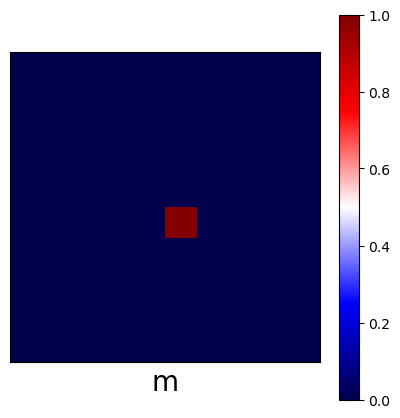

In [63]:
vmin = 0
vmax = S_bar

mat = np.reshape(m_true * S_F, (Col, Col))

plt.figure(figsize=(5,5))
plt.imshow(mat, interpolation='nearest', vmin = vmin, vmax = vmax, cmap='seismic')

plt.colorbar()

plt.xlabel('m', fontsize=20)

plt.gca().invert_yaxis()
plt.xticks([])
plt.yticks([])

plt.show()

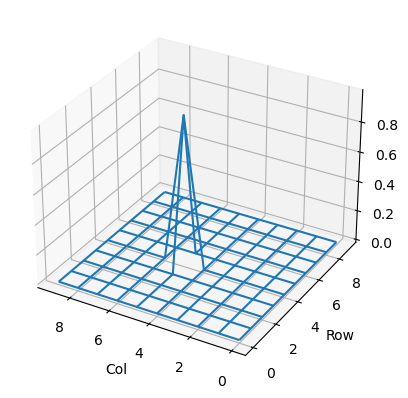

In [64]:
# 3次元行列の生成
matrix = np.reshape(m_true * S_F, (Col, Col))

# 行列の座標を作成
x, y = np.meshgrid(range(Col), range(Col))

# 3Dグラフの作成
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(x, y, matrix, cmap='viridis')

# グラフの軸ラベル設定
ax.set_xlabel('Col')
ax.set_ylabel('Row')
ax.set_zlabel('Z')

plt.gca().invert_xaxis()

# グラフ表示
plt.show()

In [65]:
prm.T

array([[0.        , 0.1       , 0.2       , ..., 1.14017543, 1.20415946,
        1.27279221],
       [0.1       , 0.        , 0.1       , ..., 1.08166538, 1.14017543,
        1.20415946],
       [0.2       , 0.1       , 0.        , ..., 1.02956301, 1.08166538,
        1.14017543],
       ...,
       [1.14017543, 1.08166538, 1.02956301, ..., 0.        , 0.1       ,
        0.2       ],
       [1.20415946, 1.14017543, 1.08166538, ..., 0.1       , 0.        ,
        0.1       ],
       [1.27279221, 1.20415946, 1.14017543, ..., 0.2       , 0.1       ,
        0.        ]])

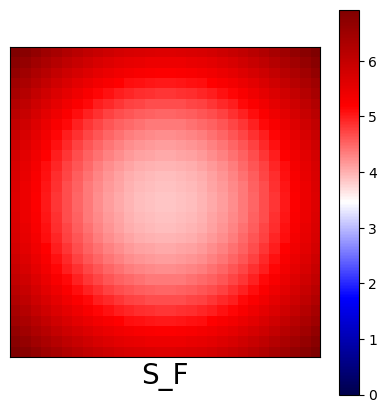

In [47]:
vmin = 0
vmax = None

mat = np.reshape(S_F, (Col, Col))

plt.figure(figsize=(5,5))
plt.imshow(mat, interpolation='nearest', vmin = vmin, vmax = vmax, cmap='seismic')
plt.colorbar()

plt.xlabel('S_F', fontsize=20)

plt.gca().invert_yaxis()
plt.xticks([])
plt.yticks([])

plt.show()

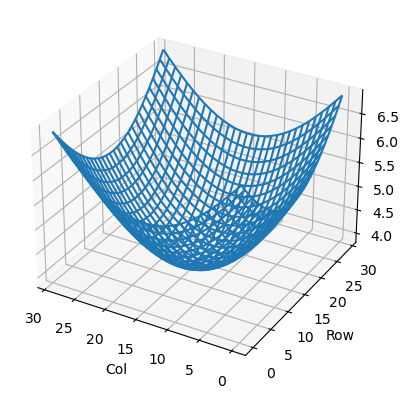

In [48]:
# 3次元行列の生成
matrix = np.reshape(S_F, (Col, Col))

# 行列の座標を作成
x, y = np.meshgrid(range(Col), range(Col))

# 3Dグラフの作成
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(x, y, matrix, cmap='viridis')

# グラフの軸ラベル設定
ax.set_xlabel('Col')
ax.set_ylabel('Row')
ax.set_zlabel('Z')

plt.gca().invert_xaxis()

# グラフ表示
plt.show()

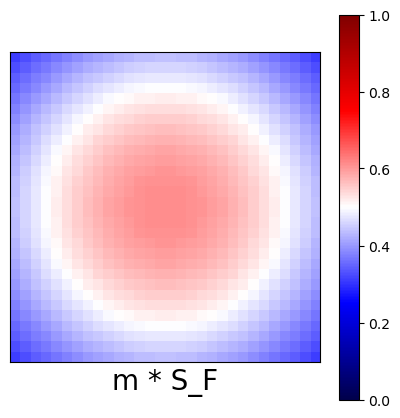

In [49]:
vmin = 0
vmax = S_bar

mat = np.reshape(m_true * S_F, (Col, Col))

plt.figure(figsize=(5,5))
plt.imshow(mat, interpolation='nearest', vmin = vmin, vmax = vmax, cmap='seismic')

plt.colorbar()

plt.xlabel('m * S_F', fontsize=20)

plt.gca().invert_yaxis()
plt.xticks([])
plt.yticks([])

plt.show()

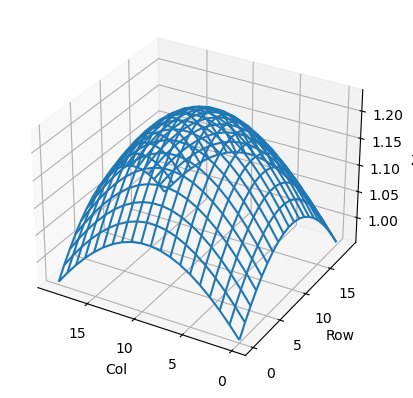

In [33]:
# 3次元行列の生成
matrix = np.reshape(m_true * S_F, (Col, Col))

# 行列の座標を作成
x, y = np.meshgrid(range(Col), range(Col))

# 3Dグラフの作成
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(x, y, matrix, cmap='viridis')

# グラフの軸ラベル設定
ax.set_xlabel('Col')
ax.set_ylabel('Row')
ax.set_zlabel('Z')

plt.gca().invert_xaxis()

# グラフ表示
plt.show()